In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive


Mounted at /gdrive
/gdrive


In [ ]:
Image_size = 256
Batch_size = 32
channels = 3
trainfile = r'/gdrive/My Drive/CIS_508/Sample_project/Potato_Project'

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    trainfile,
    shuffle=True,
    image_size=(Image_size,Image_size),
    batch_size = Batch_size
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset)

68

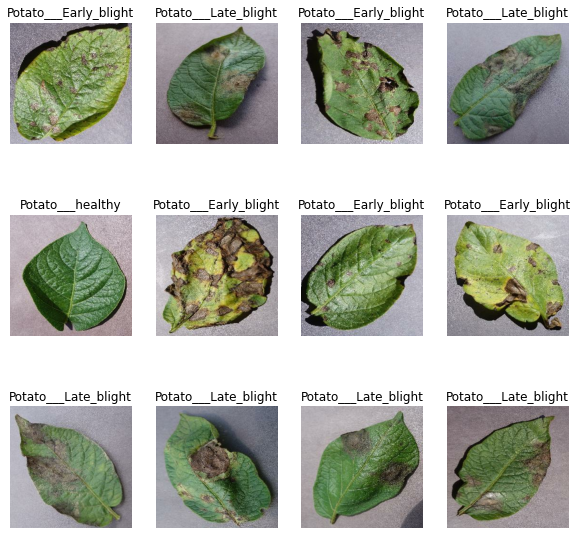

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
#    print(image_batch[0].shape)
    for i in range (12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint'))
        plt.title(class_names[label_batch[i]])
        #plt.grid('on')
        plt.axis("off")

Performing train test split

train=> 80
test=>20

In [ ]:
train_size = .8
print(len(dataset)*train_size )

train_ds = dataset.take(54) #arr[:54]

54.400000000000006


In [ ]:
len(train_ds)

54

In [ ]:
test_ds = dataset.skip(54) #arr[54:]
len(test_ds)

14

In [ ]:
val_size = 0.1
len(dataset) * val_size

6.800000000000001

In [ ]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [ ]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [ ]:
#writing a function to perform the above split

def df_get_dataset_partision(ds, train_split=0.8, test_split=0.1, val_split=0.1, shuffle=True, shuffle_size = 10000):
    
    ds_size = len(ds)
    
    train_size = int(train_split * ds_size )
    val_size = int(val_split * ds_size)
    
    tarin_ds = ds.take(train_size)
    
    test_ds = ds.take(train_size).skip(val_size)
    val_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, test_ds, val_ds

In [ ]:
train_ds, test_ds, val_ds = df_get_dataset_partision(dataset)

In [ ]:
len(train_ds)

54

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_size,Image_size),
    layers.experimental.preprocessing.Rescaling(0.1/255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

# Building the model

In [ ]:
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu', input_shape = (Batch_size, Image_size,Image_size, channels)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax') #softmax will normalise the probability of the clases
    
])
model.build(input_shape=(Batch_size, Image_size,Image_size,channels))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
import tensorflow as tf 
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

In [ ]:
model_ev = model.fit(
    train_ds,   
    epochs = 50,
    batch_size = Batch_size,
    verbose = 1,
    validation_data=val_ds,
    callbacks = early_stopping
)

Epoch 1/50
54/54 [==============================] - 166s 444ms/step - loss: 0.9259 - accuracy: 0.4421 - val_loss: 0.8555 - val_accuracy: 0.5000
Epoch 2/50
54/54 [==============================] - 7s 122ms/step - loss: 0.7748 - accuracy: 0.6447 - val_loss: 0.4118 - val_accuracy: 0.8534
Epoch 3/50
54/54 [==============================] - 6s 110ms/step - loss: 0.5430 - accuracy: 0.7847 - val_loss: 0.4270 - val_accuracy: 0.8405
Epoch 4/50
54/54 [==============================] - 5s 100ms/step - loss: 0.4327 - accuracy: 0.8328 - val_loss: 0.3664 - val_accuracy: 0.8750
Epoch 5/50
54/54 [==============================] - 7s 122ms/step - loss: 0.4019 - accuracy: 0.8339 - val_loss: 0.4767 - val_accuracy: 0.8017
Epoch 6/50
54/54 [==============================] - 6s 110ms/step - loss: 0.4111 - accuracy: 0.8247 - val_loss: 0.2844 - val_accuracy: 0.8879
Epoch 7/50
54/54 [==============================] - 5s 99ms/step - loss: 0.3740 - accuracy: 0.8484 - val_loss: 0.3159 - val_accuracy: 0.8750
Epoch

In [ ]:
model_ev.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

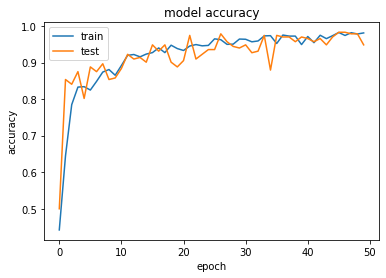

In [ ]:
# summarized history for accuracy
plt.plot(model_ev.history['accuracy'])
plt.plot(model_ev.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
scores = model.evaluate(test_ds)

48/48 [==============================] - 5s 32ms/step - loss: 0.1947 - accuracy: 0.9368


In [ ]:
model_ev.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

image to predict
actual label Potato___Early_blight
1/1 [==============================] - 0s 171ms/step
predicted label Potato___Early_blight


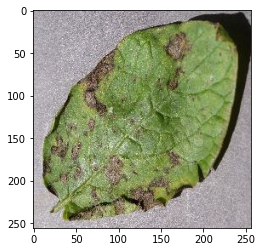

In [ ]:
# this code shows how each prediction is done
import numpy as np
for image_batch, labels_batch in test_ds.take(1): # I assume label batch is the number of the image or the class of the image.  image batch is the batch of the image
  first_image = image_batch[1].numpy().astype('uint') 
  first_label = labels_batch[1].numpy()

  print('image to predict')
  plt.imshow(first_image)
  print('actual label',class_names[first_label])

  batch_prediction = model.predict(image_batch)
  print('predicted label', class_names[np.argmax(batch_prediction[1])])

In [ ]:
# this is a function to predict and get the confidence level. Basicllty using the argmax function and using the softmax results and multiply by 100
def predict (model,img):
  img_array = tf.keras.preprocessing.image.img_to_array(image[i].numpy())
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)

  prediction_class = class_names[np.argmax(predictions[0])]
  confidence = round (100* (np.max(predictions[0])), 2)
  return prediction_class, confidence

1/1 [==============================] - 0s 19ms/step


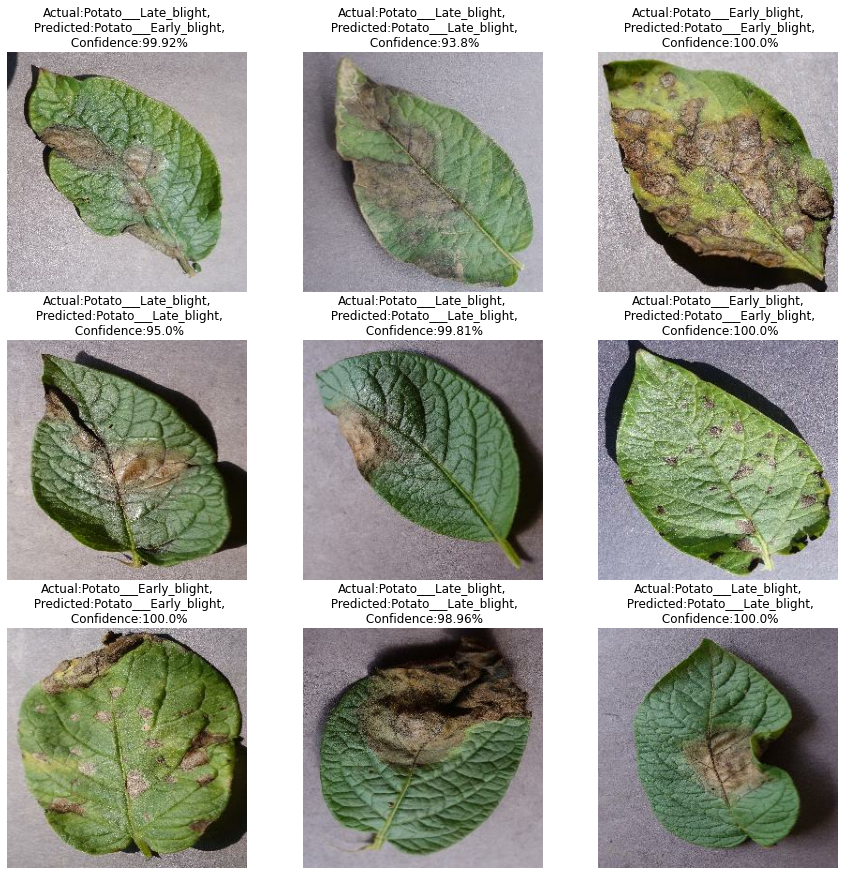

In [ ]:
# this is used to do the batch predictions and give us the output for some test data
plt.figure(figsize=(15,15))
for image, labels in test_ds.take(1):
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(image[i].numpy().astype('uint'))

    predicted_class, confidence = predict(model, image[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual:{actual_class},\n Predicted:{predicted_class},\n Confidence:{confidence}%")
    plt.axis('off')

In [ ]:
import os
model_version = max([int(i) for i in os.listdir(r'/gdrive/My Drive/CIS_508/Sample_project/models') + [0]])+1
model.save(r'/gdrive/My Drive/CIS_508/Sample_project/models')

FileNotFoundError: ignored

In [ ]:
#  model_version=2
#  model.save(f'../models/{model_version}')

In [ ]:
import os
model_version = max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f'/gdrive/My Drive/CIS_508/Sample_project/Potato_Project/models/{model_version}')